<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

## Libraries and GloVe

In [ ]:
import tensorflow as tf
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import TextVectorization, Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Get GloVe from the web
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-05-16 14:43:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-16 14:43:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-16 14:43:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Binary model

### Dataset

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  38.0M      0  0:00:02  0:00:02 --:--:-- 38.0M


In [ ]:
# Directory path
dataset_dir = "aclImdb"

# Remove unsup data (not labeled)
shutil.rmtree(os.path.join(dataset_dir, 'train', 'unsup'))

# Load training and test sets
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    batch_size=batch_size
)

# To train the Final Model
full_train_ds = train_ds.concatenate(val_ds).shuffle(10000)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
max_vocab = 20000
sequence_len = 300

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_mode='int',
    output_sequence_length=sequence_len
)

# Adapt vectorizer on training data
text_only_train = train_ds.map(lambda x, y: x)
vectorizer.adapt(text_only_train)

In [ ]:
# Convert datasets to NumPy arrays or tensors
def vectorize_dataset(ds):
    return ds.map(lambda x, y: (vectorizer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = vectorize_dataset(train_ds)
val_ds = vectorize_dataset(val_ds)
test_ds = vectorize_dataset(test_ds)
full_train_ds = vectorize_dataset(full_train_ds)


### Model 1
val_accuracy = 0.8772

In [ ]:
model1 = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
#    layers.GlobalAveragePooling1D(),      # either this
    layers.GlobalMaxPooling1D(),           # or this
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])

model1.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["accuracy"])

In [ ]:
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model1.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6896 - loss: 0.5846 - val_accuracy: 0.8634 - val_loss: 0.3248
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8933 - loss: 0.2603 - val_accuracy: 0.8752 - val_loss: 0.2895
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9497 - loss: 0.1452 - val_accuracy: 0.8750 - val_loss: 0.3213
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9832 - loss: 0.0611 - val_accuracy: 0.8716 - val_loss: 0.3706
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9972 - loss: 0.0198 - val_accuracy: 0.8778 - val_loss: 0.4203


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,687,061 (29.32 MB)

 Trainable params: 2,562,353 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,124,708 (19.55 MB)

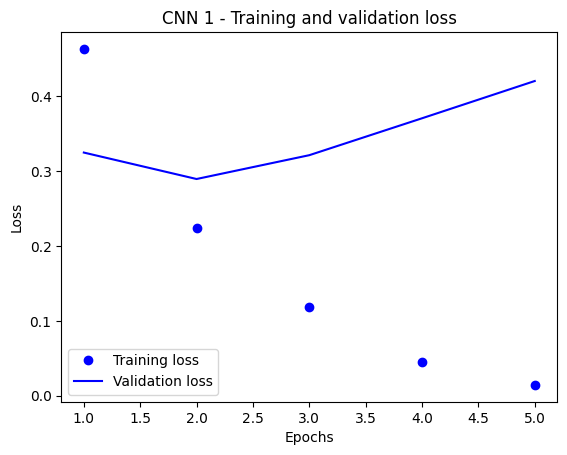

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

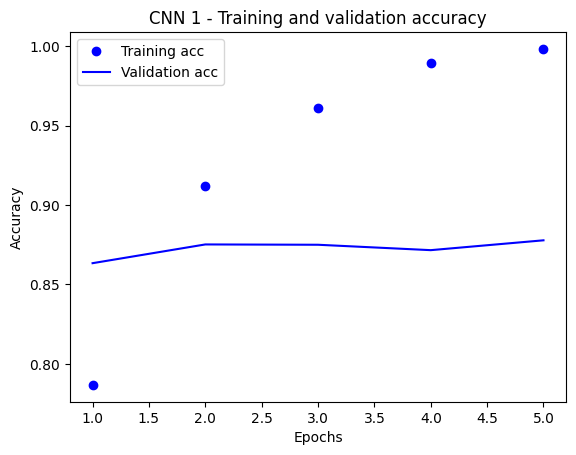

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 2
val_accuracy = 0.8870

In [ ]:
model2 = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),  # Sequence → single vector    TEST WITHOUT

    # Dense layer 1
    layers.Dense(8, activation='relu'),

    # Dense layer 2
    layers.Dense(8, activation='relu'),

    # Dense layer 3 (Output)
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model2.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6000 - loss: 0.6548 - val_accuracy: 0.8514 - val_loss: 0.3547
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8519 - loss: 0.3412 - val_accuracy: 0.8646 - val_loss: 0.3110
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8943 - loss: 0.2591 - val_accuracy: 0.8636 - val_loss: 0.3125
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9155 - loss: 0.2184 - val_accuracy: 0.8630 - val_loss: 0.3212
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9227 - loss: 0.2081 - val_accuracy: 0.8878 - val_loss: 0.2908
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9257 - loss: 0.1934 - val_accuracy: 0.8452 - val_loss: 0.4066
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9318 - loss: 0.1746 - val_accuracy: 0.8796 - val_loss: 0.3315
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9485 - loss: 0.1435 - val_accuracy: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,341 (29.31 MB)

 Trainable params: 2,561,113 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,122,228 (19.54 MB)

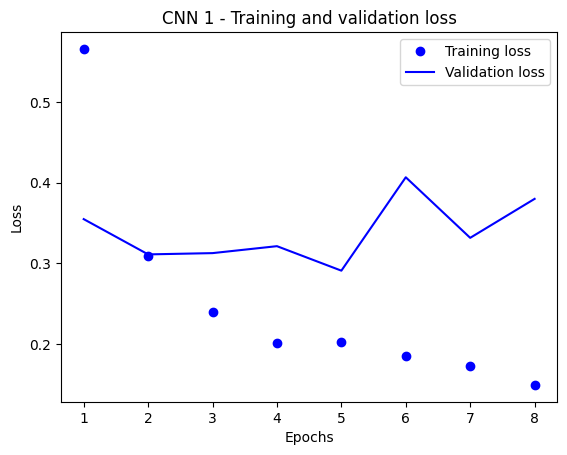

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

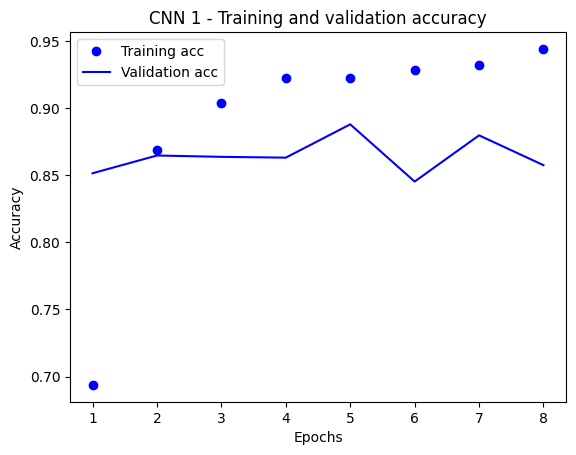

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 3
val_accuracy = 0.8720

In [ ]:
embedding_dim = 100
glove_path = "glove.6B.100d.txt"

# Load GloVe
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model3 = models.Sequential([
    layers.Embedding(
        input_dim=len(vocab),
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    ),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),  # Stronger signal
    layers.GlobalMaxPooling1D(),  # Focus on the most important time steps
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model3.summary()

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.6482 - loss: 0.6012 - val_accuracy: 0.8384 - val_loss: 0.3683
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.8393 - loss: 0.3752 - val_accuracy: 0.8586 - val_loss: 0.3306
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8737 - loss: 0.3168 - val_accuracy: 0.8682 - val_loss: 0.3107
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8976 - loss: 0.2672 - val_accuracy: 0.8724 - val_loss: 0.3183
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9142 - loss: 0.2245 - val_accuracy: 0.8716 - val_loss: 0.3112
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.9353 - loss: 0.1879 - val_accuracy: 0.8640 - val_loss: 0.3471


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 100)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,278,405 (8.69 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 185,604 (725.02 KB)

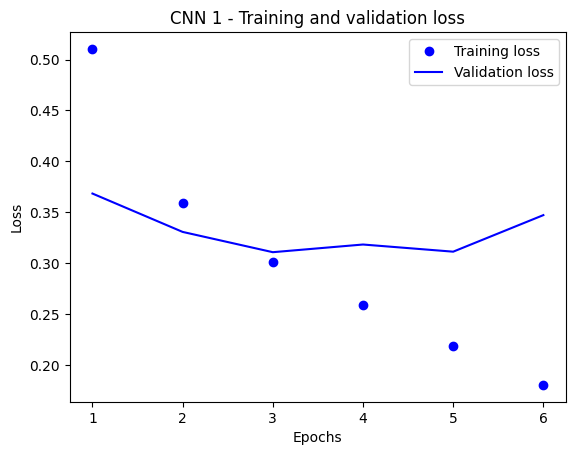

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

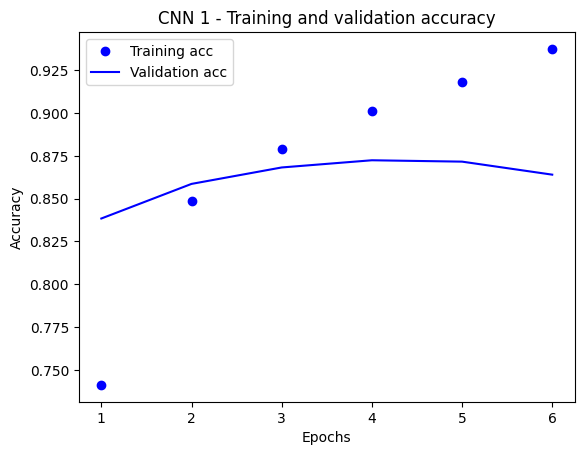

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final Binary Model (model 2)

In [ ]:
model_binary = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),  # Sequence → single vector    TEST WITHOUT

    # Dense layer 1
    layers.Dense(8, activation='relu'),

    # Dense layer 2
    layers.Dense(8, activation='relu'),

    # Dense layer 3 (Output)
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model_binary.fit(
    full_train_ds,
    validation_data = test_ds,
    epochs=20,
    callbacks = [
        EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True, mode='max'),
        ModelCheckpoint('best_model_binary.h5', monitor='val_accuracy', save_best_only=True, mode='max')]
)

model_binary.summary()

Epoch 1/20
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5872 - loss: 0.6363

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5876 - loss: 0.6359 - val_accuracy: 0.8264 - val_loss: 0.3757
Epoch 2/20
770/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8673 - loss: 0.3148

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8675 - loss: 0.3144 - val_accuracy: 0.8604 - val_loss: 0.3282
Epoch 3/20
764/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9003 - loss: 0.2486

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9005 - loss: 0.2481 - val_accuracy: 0.8715 - val_loss: 0.3158
Epoch 4/20
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9194 - loss: 0.2094

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9195 - loss: 0.2093 - val_accuracy: 0.8749 - val_loss: 0.3236
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9194 - loss: 0.2097 - val_accuracy: 0.8524 - val_loss: 0.4011
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9268 - loss: 0.1908 - val_accuracy: 0.8220 - val_loss: 0.5351
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9455 - loss: 0.1509 - val_accuracy: 0.8386 - val_loss: 0.5300
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9451 - loss: 0.1515 - val_accuracy: 0.7966 - val_loss: 0.7192
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9381 - loss: 0.1568 - val_accuracy: 0.7684 - val_loss: 0.9421
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9433 - loss: 0.1517 - val_accuracy: 0.7776 - val_loss: 0.9389
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9531 - loss: 0.1270 - val_accuracy: 0.7861 - va

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,341 (29.31 MB)

 Trainable params: 2,561,113 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,122,228 (19.54 MB)

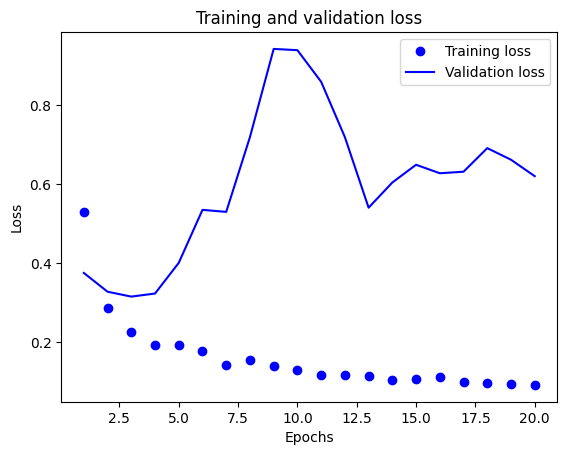

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

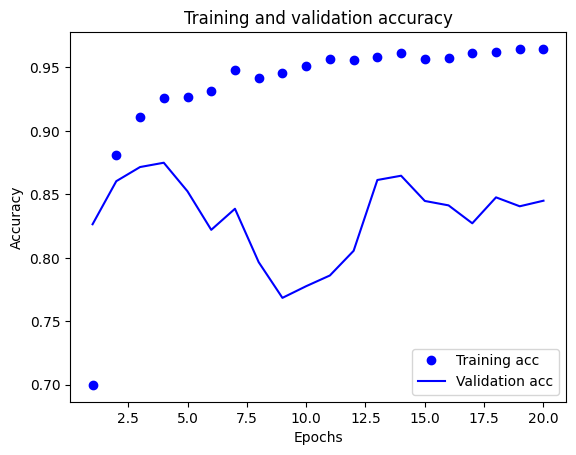

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# def predict_binary(text):
#    text_tensor = tf.convert_to_tensor([text])
#    pred = model_binary.predict(text_tensor)[0][0]
#    return "positive" if pred >= 0.5 else "negative"

# print(predict_binary("The direction and cinematography were absolutely brilliant."))
# print(predict_binary("So bad I would watch it again."))
# print(predict_binary("Bad."))
# print(predict_binary("I did not like it."))

## Multi-class model

### Dataset

In [ ]:
# Unzip to a folder
!unzip emotions-goemotions.zip -d emotions_data

Archive:  emotions-goemotions.zip
   creating: emotions_data/goemotions/
  inflating: emotions_data/goemotions/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/._.DS_Store  
   creating: emotions_data/goemotions/data/
  inflating: emotions_data/__MACOSX/goemotions/._data  
  inflating: emotions_data/goemotions/data/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/data/._.DS_Store  
   creating: emotions_data/goemotions/data/full_dataset/
  inflating: emotions_data/__MACOSX/goemotions/data/._full_dataset  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_1.csv  
  inflating: emotions_data/__MACOSX/goemotions/data/full_dataset/._goemotions_1.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_3.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_2.csv  


In [ ]:
dataset = pd.read_csv('emotions_data/goemotions/data/full_dataset/goemotions_1.csv')

In [ ]:
dataset.drop(columns=["id","author","subreddit","link_id","parent_id","created_utc","rater_id","example_very_unclear"], inplace=True)

In [ ]:
# vectorizer.adapt(dataset['text'].values)

X = vectorizer(dataset['text'].values)

y = dataset.drop(columns=['text'])

In [ ]:
X_numpy = X.numpy() if isinstance(X, tf.Tensor) else X
X_train_full, X_test, y_train_full, y_test = train_test_split(X_numpy, y, test_size=0.2, random_state=42)

# Second split: Take 20% of training for validation (16% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42
)

### Model 4

In [ ]:
max_tokens = len(vocab)  # Size of vocabulary
embedding_dim = 100       # Must match your embedding_matrix dimension

# Create model with CNN and LSTM layers
model4 = models.Sequential([
    layers.Embedding(input_dim=max_tokens,
                     output_dim=embedding_dim,
                     embeddings_initializer=initializers.Constant(embedding_matrix),
                     trainable=False),

    layers.Conv1D(128, 5, activation='relu'),  # CNN layer with 128 filters and kernel size 5
    layers.MaxPooling1D(2),  # Max pooling to downsample

    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    layers.GlobalMaxPooling1D(),  # Global max pooling to reduce dimensionality

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='sigmoid')
])


In [ ]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [ ]:
# Fit the model
history = model4.fit(X_train,
                     y_train,
                     validation_data=(X_val, y_val),
                     epochs=20,
                     batch_size=64,callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, restore_best_weights=True)]
                     )

model4.summary()

Epoch 1/20
549/700 ━━━━━━━━━━━━━━━━━━━━ 1:19 525ms/step - AUC: 0.5942 - loss: 0.2642

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["AUC"]
val_acc = history_dict["val_AUC"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 5

In [ ]:
model5 = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(28, activation='sigmoid')
])

In [ ]:
model5.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])

In [ ]:
history = model5.fit(X_train, y_train,
                     epochs=50,
                     batch_size=32,
                     validation_data=(X_val, y_val),
                     callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True)
)
model5.summary()

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["AUC"]
val_acc = history_dict["val_AUC"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final Multi-class Model (model 5)

In [ ]:
model_multi_class = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(28, activation='sigmoid')
])

model_multi_class.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])

In [ ]:
history = model_multi_class.fit(X_train_full,
                                y_train_full,
                                epochs=50,
                                batch_size=32,
                                validation_data=(X_val, y_val),
                                callbacks = [
                                    EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True),
                                    ModelCheckpoint('best_model_multi.h5', monitor='val_AUC', save_best_only=True, mode='max')]
)
model_multi_class.summary()

## Merging **Binary** and **Multi class** models

In [ ]:
# Define emotion labels (adjust to your actual labels)
emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
                  'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
                  'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
                  'remorse', 'sadness', 'surprise', 'neutral']

def predict_text(text, threshold=0.3):
    # Convert to batch shape and vectorize
    input_text = tf.convert_to_tensor([text])
    vectorized = vectorizer(input_text)

    # Binary sentiment
    sentiment_prob = model_binary.predict(input_text)[0][0]
    sentiment_label = 'positive' if sentiment_prob >= 0.5 else 'negative'

    # Multi-label emotion
    emotion_probs = model_multi_class.predict(vectorized)[0]
    predicted_emotions = [emotion_labels[i] for i, p in enumerate(emotion_probs) if p >= threshold]

    return {
        "text": text,
        "sentiment": sentiment_label,
        "sentiment_score": float(sentiment_prob),
        "emotions": predicted_emotions,
        "emotion_scores": {emotion_labels[i]: float(emotion_probs[i]) for i in range(len(emotion_probs))}
    }

In [ ]:
result = predict_text("I'm not happy about what happened, but I understand.")
print(result)

In [ ]:
def create_ensemble_model(sentiment_model_path, emotion_model_path):
    # Load the models
    sentiment_model = load_model(sentiment_model_path)
    emotion_model = load_model(emotion_model_path)

    # Freeze the models to prevent training
    sentiment_model.trainable = False
    emotion_model.trainable = False

    # Define new input layers
    sentiment_input = Input(shape=sentiment_model.input_shape[1:], name="sentiment_input")
    emotion_input = Input(shape=emotion_model.input_shape[1:], name="emotion_input")

    # Pass the inputs through the respective models
    sentiment_output = sentiment_model(sentiment_input)
    emotion_output = emotion_model(emotion_input)

    # Create the joint model
    joint_model = Model(
        inputs=[sentiment_input, emotion_input],
        outputs=[sentiment_output, emotion_output]
    )

    return joint_model

In [ ]:
joint_model=create_ensemble_model('best_model_binary.h5', 'best_model_multi.h5')

In [ ]:
joint_model.summary()

In [ ]:
# Define emotion labels (adjust to your actual labels)
emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
                  'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
                  'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
                  'remorse', 'sadness', 'surprise', 'neutral']

def predict_ensemble_model(model, texts, vectorizer, emotion_labels=emotion_labels, max_length=300, neutral_threshold=0.3, emotion_threshold=0.15):
    # Tokenize and pad the input texts
    input = vectorizer(texts)

    # Make predictions with the joint model
    predictions = model.predict({
        'sentiment_input': input,
        'emotion_input': input
    })

    # Get the sentiment prediction
    sentiment_prediction = predictions[0]

    # Convert sentiment prediction to 'positive' or 'negative' based on threshold of 0.5
    sentiment_label = "positive" if sentiment_prediction[0] > 0.5 else "negative"

    # Get emotion predictions
    emotion_predictions = predictions[1]

    # Map the emotion predictions to the emotion labels
    emotion_results = {emotion_labels[i]: emotion_predictions[0][i] for i in range(len(emotion_labels))}

    # Check if 'neutral' emotion has score > neutral_threshold
    if emotion_results.get('neutral', 0) >= neutral_threshold:
        # If neutral is above the threshold, only return "neutral"
        return {
            'sentiment': sentiment_label,
            'emotion': ['neutral']
        }

    # Filter emotions: return all emotions > emotion_threshold, excluding 'neutral'
    filtered_emotions = {emotion: score for emotion, score in emotion_results.items() if score > emotion_threshold and emotion != 'neutral'}

    # If no emotions are above the threshold, return only the emotion with the highest score, excluding 'neutral'
    if not filtered_emotions:
        max_emotion = max((emotion_results[key], key) for key in emotion_results if key != 'neutral')
        filtered_emotions = {max_emotion[1]: max_emotion[0]}

    # Return the predictions
    return {
        'sentiment': sentiment_label,  # Sentiment prediction as 'positive' or 'negative'
        'emotion': list(filtered_emotions.keys())  # List of emotions above threshold or best emotion
    }


In [ ]:
predict_ensemble_model(joint_model, ["I am so excited!"], vectorizer)